### Установка зависимостей

In [238]:
import torch
import numpy as np
from torch.utils.data.sampler import WeightedRandomSampler

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [240]:
import PIL
print(PIL.__version__)

9.5.0


In [241]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Oct 14 09:23:46 2024       

True


+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   26C    P5             16W /   30W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+------------------------+-----------

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [242]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader, TensorDataset

from matplotlib import colors, pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [243]:
DATA_MODES = ['train', 'val', 'test']

RESCALE_SIZE = 256

DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [244]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        x = self.load_sample(self.files[index])
        if self.mode == 'train':
            x = self._augment_sample(x)

        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

    def _augment_sample(self, image):
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=(-15,15)),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
            transforms.RandomResizedCrop(RESCALE_SIZE, scale=(0.8, 1.0)),
        ])
            
        
        return transform(image)


    def _apply_oversampling(self):
        """
        Применение oversampling с использованием SMOTE
        """
        
        loader = DataLoader(self, batch_size=self.len_, shuffle=False)
        X_train, y_train = next(iter(loader))

       
        X_train = X_train.numpy().reshape(self.len_, -1)
        y_train = y_train.numpy()

        
        sm = SMOTE(random_state=42)
        X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

        
        X_resampled = torch.tensor(X_resampled.reshape(-1, 3, RESCALE_SIZE, RESCALE_SIZE), dtype=torch.float32)
        y_resampled = torch.tensor(y_resampled, dtype=torch.long)

        
        self.files = X_resampled
        self.labels = y_resampled
        self.len_ = len(self.files)

In [245]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [246]:

TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [247]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [248]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [249]:
val_dataset = SimpsonsDataset(val_files, mode='val')
num_classes = len(val_dataset.label_encoder.classes_)


In [250]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

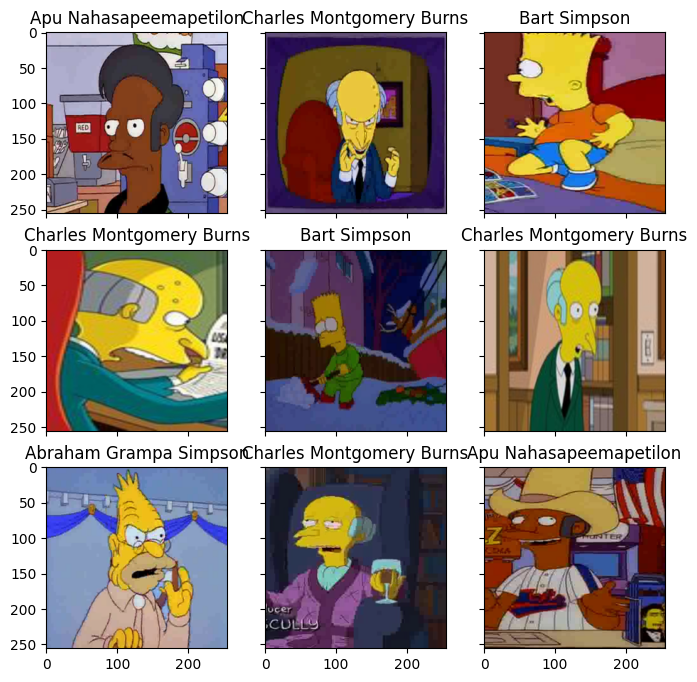

In [251]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети




In [252]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in C:\Users\masko/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\masko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\masko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [253]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [254]:
model.fc = nn.Linear(model.fc.in_features, num_classes)

for param in model.parameters():  
    param.requires_grad = False
for param in model.layer4.parameters():  
    param.requires_grad = True
for param in model.fc.parameters():  
    param.requires_grad = True


print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [255]:
model = model.to(DEVICE)



In [256]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in tqdm(train_loader, desc='train', leave=True):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [257]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in tqdm(val_loader, desc='valid', leave=True):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [258]:
def train(train_files, val_files, model, epochs, batch_size, optimizer, scheduler, l2_lambda=0.01):
    
    train_dataset = SimpsonsDataset(train_files, mode='train')
    val_dataset = SimpsonsDataset(val_files, mode='val')

    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    
    criterion = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=optimizer.param_groups[0]['lr'], weight_decay=l2_lambda)

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

           
            if scheduler:
                scheduler.step(val_loss)

    return history


In [259]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Запустим обучение сети.

In [260]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)



c:\Users\masko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [261]:
history = train(train_files, val_files, model, epochs=10, batch_size=256, optimizer=optimizer, scheduler=scheduler, l2_lambda=0.01)


train: 100%|██████████| 62/62 [04:13<00:00,  4.09s/it]


loss 1.939772532551036


epoch:  10%|█         | 1/10 [05:03<45:35, 303.93s/it]


Epoch 001 train_loss: 1.9398     val_loss 0.9342 train_acc 0.5790 val_acc 0.8103


train: 100%|██████████| 62/62 [04:04<00:00,  3.95s/it]


loss 0.6193069532229813


epoch:  20%|██        | 2/10 [09:56<39:39, 297.38s/it]


Epoch 002 train_loss: 0.6193     val_loss 0.5875 train_acc 0.8480 val_acc 0.8500


train: 100%|██████████| 62/62 [04:05<00:00,  3.96s/it]


loss 0.41490381257504716


epoch:  30%|███       | 3/10 [14:50<34:30, 295.82s/it]


Epoch 003 train_loss: 0.4149     val_loss 0.4055 train_acc 0.8916 val_acc 0.8997


train: 100%|██████████| 62/62 [04:13<00:00,  4.09s/it]


loss 0.33651685576995805


epoch:  40%|████      | 4/10 [19:54<29:53, 298.85s/it]


Epoch 004 train_loss: 0.3365     val_loss 0.3589 train_acc 0.9133 val_acc 0.9100


train: 100%|██████████| 62/62 [04:13<00:00,  4.09s/it]


loss 0.29381980108234473


epoch:  50%|█████     | 5/10 [24:57<25:02, 300.44s/it]


Epoch 005 train_loss: 0.2938     val_loss 0.4215 train_acc 0.9235 val_acc 0.8884


train: 100%|██████████| 62/62 [04:09<00:00,  4.03s/it]


loss 0.26974774400203333


epoch:  60%|██████    | 6/10 [29:54<19:57, 299.40s/it]


Epoch 006 train_loss: 0.2697     val_loss 0.3786 train_acc 0.9324 val_acc 0.9028


train: 100%|██████████| 62/62 [04:49<00:00,  4.66s/it]


loss 0.250633890448167


epoch:  70%|███████   | 7/10 [35:55<15:58, 319.35s/it]


Epoch 007 train_loss: 0.2506     val_loss 0.3320 train_acc 0.9339 val_acc 0.9217


train: 100%|██████████| 62/62 [06:58<00:00,  6.76s/it]


loss 0.24339936741127832


epoch:  80%|████████  | 8/10 [44:05<12:27, 373.84s/it]


Epoch 008 train_loss: 0.2434     val_loss 0.3600 train_acc 0.9362 val_acc 0.9052


train: 100%|██████████| 62/62 [06:55<00:00,  6.70s/it]


loss 0.2475161586030136


epoch:  90%|█████████ | 9/10 [52:11<06:48, 408.82s/it]


Epoch 009 train_loss: 0.2475     val_loss 0.3297 train_acc 0.9358 val_acc 0.9196


train: 100%|██████████| 62/62 [06:59<00:00,  6.76s/it]


loss 0.22721120463419026


epoch: 100%|██████████| 10/10 [1:00:58<00:00, 365.84s/it]


Epoch 010 train_loss: 0.2272     val_loss 0.3093 train_acc 0.9439 val_acc 0.9232


Построим кривые обучения

In [262]:
loss, acc, val_loss, val_acc = zip(*history)

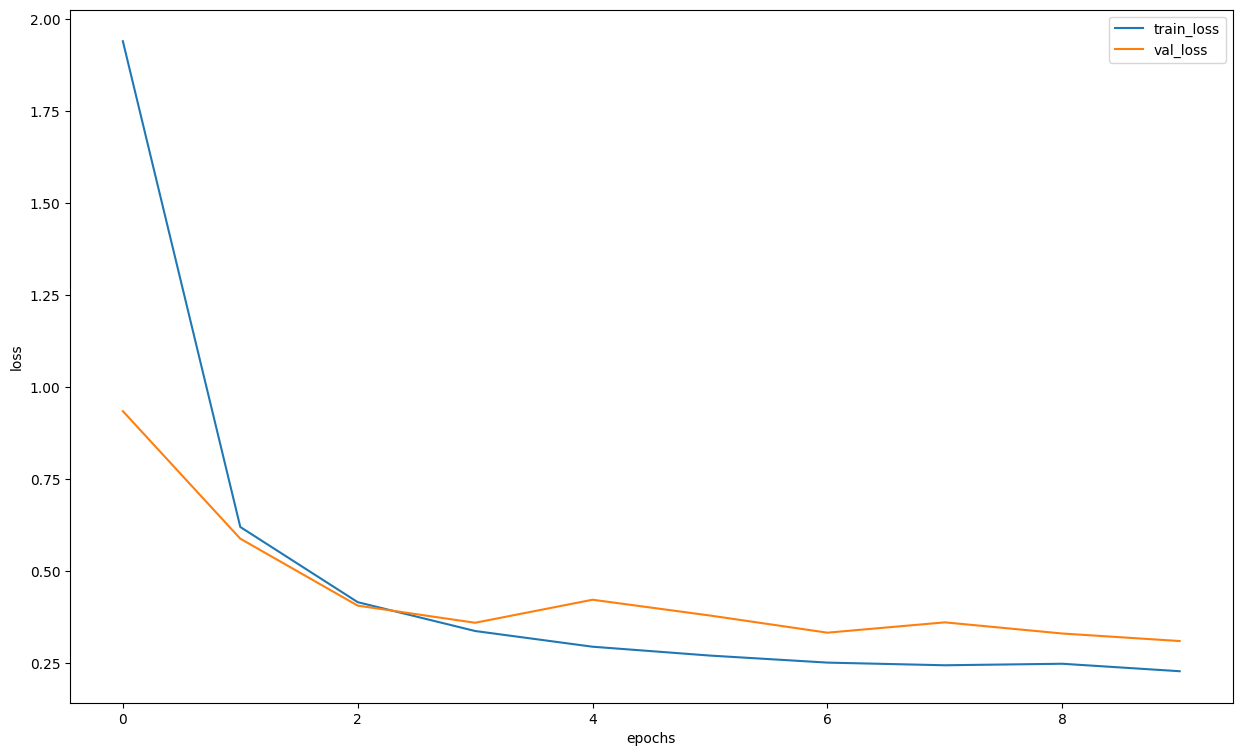

In [263]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [264]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [265]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [266]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [267]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [268]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [269]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 0.95


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

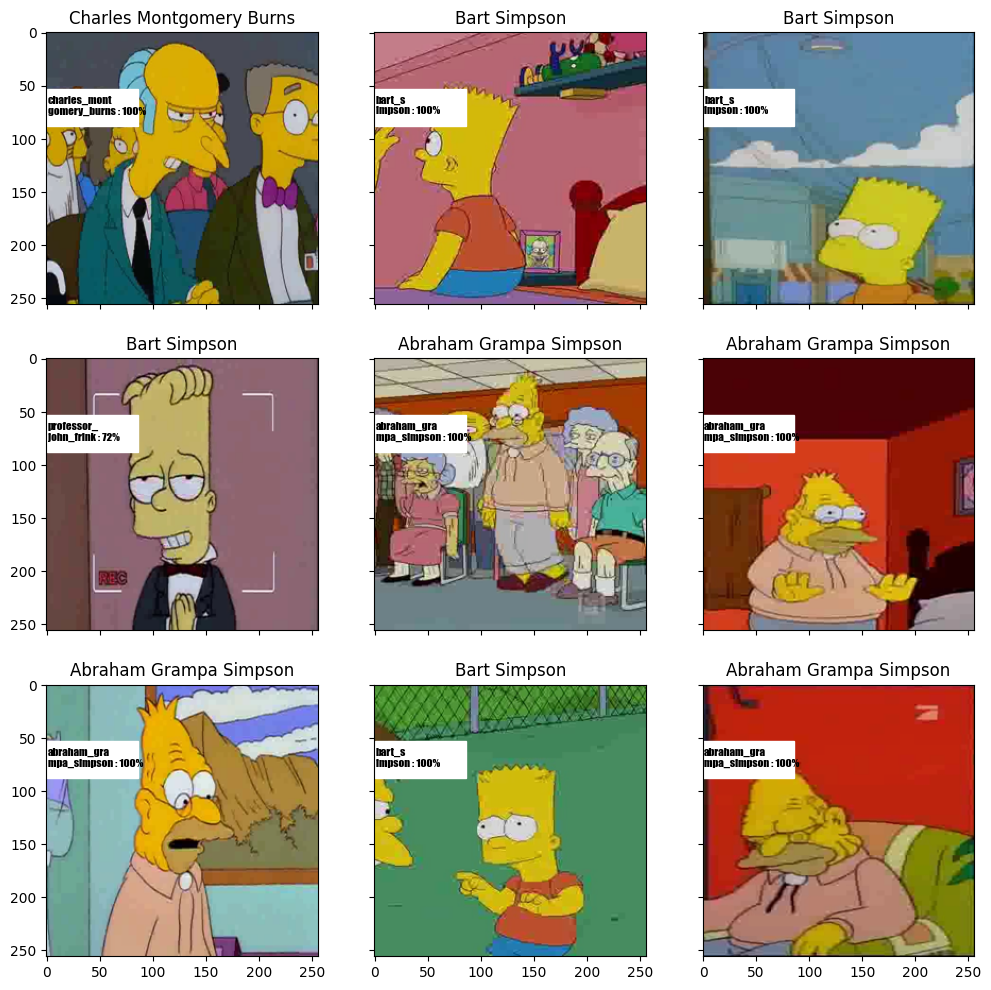

In [173]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')